In [29]:
### Import packages
# Processing
import glob
import os
import SimpleITK as sitk
import numpy as np
import tables
import nibabel
from matplotlib import pyplot as plt 
from nilearn import plotting
import pandas as pd
# Model
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import Sequential
from keras.layers import Dense
# HDF5
from keras.utils.io_utils import HDF5Matrix
import h5py
# Generator
from random import shuffle
import pickle

In [30]:
## Dictionary
config = dict()
config["image_shape"] = (32,32,32)#(144, 144, 144) 
config["labels"] = (1, 2, 4)  # the label numbers on the input image
config["n_labels"] = len(config["labels"])
config["all_modalities"] = ["t1", "t1ce", "flair", "t2"]
config["training_modalities"] = config["all_modalities"]  
config["nb_channels"] = len(config["training_modalities"])
config["input_shape"] = tuple(list(config["image_shape"])+[config["nb_channels"]])
print('Input shape',config['input_shape'])
#config['data_file']=os.path.join('/home/vjain/notebooks/3DUnetCNN/brats','brats_data.h5')
config["data_file"] = os.path.abspath('brats_data.h5')
data_file=config['data_file']
#config["training_file"] = os.path.join('/home/vjain/notebooks/3DUnetCNN/brats',"training_ids.pkl")
config["training_file"] = os.path.abspath('training_ids.pkl')
#config["validation_file"] = os.path.join('/home/vjain/notebooks/3DUnetCNN/brats',"validation_ids.pkl")
config["validation_file"] = os.path.abspath('validation_ids.pkl')

Input shape (32, 32, 32, 4)


In [31]:
# Declare relations
validation_keys_file=config["validation_file"],
training_keys_file=config["training_file"],
n_labels=config["n_labels"],
n_labels,=n_labels
labels=config["labels"],
training_file=training_keys_file
validation_file=validation_keys_file

In [32]:
# Define Data generator: Training and Validation -- Batch_size 1

def data_gen(data_file, ids_file, labels, batch_size=1): 
    
     with (open(ids_file, "rb")) as keys_file, open(data_file,'rb') as data_file:
        
        # Load indices: Train/Val
        index_file=pickle.load(keys_file)
        orig_index_list = index_file
        # Define Data and Target lists
        x_list = list()
        y_list = list()
        index_file= list(copy.copy(orig_index_list))
        print('index_list',index_file)
        shuffle_index_list=True
        if shuffle_index_list:
            shuffle(index_file)
        while len(index_file) > 0:
                index = index_file.pop()
                print('index',index)
                # Extract training data corresponding to indices
                for idx in index_file:
                    X_data = HDF5Matrix(data_file, 'data',0,None)
                    X_data=X_data[idx]
                    print('X_data.shape',X_data.shape)
                    X_data=np.reshape(X_data,(X_data.shape[1],X_data.shape[2],X_data.shape[3],X_data.shape[0]))
                    Y_mask = HDF5Matrix(data_file, 'truth',0,None)
                    Y_mask=Y_mask[idx]
                    Y_mask=np.reshape(Y_mask,(Y_mask.shape[1],Y_mask.shape[2],Y_mask.shape[3],Y_mask.shape[0]))
                    print('Reshaped data',X_data.shape)
                    print('Reshaped mask',Y_mask.shape)
                    x_list.append(X_data)
                    y_list.append(Y_mask)
                    # Convert HDF5 data to numpy arrays
                    x = np.asarray(x_list)
                    y = np.asarray(y_list)
                    print('x',x.shape)
                    print('y', y.shape)
                    if len(x) == batch_size or len(x) > 0:
                        # Translate labels to binary
                        n_labels=3
                        labels=config["labels"]
                        new_shape = [y.shape[0],n_labels] + list(y.shape[1:4])
                    
                        y_new= np.zeros(new_shape, np.int8)
                        print('y_new',y_new.shape)
                        for label_index in range(n_labels):
                            if labels is not None:
                                y_new[:, label_index][y_new[:, 0] == labels[label_index]] = 1
                            else:
                                y_new[:, label_index][y_new[:, 0] == (label_index + 1)] = 1
                        print('y_new shape in multiclass',y_new.shape)
                    
                    #y_reshape=np.reshape(y_new,(y_new.shape[3],y_new.shape[2],y_new.shape[1],y_new.shape[0],y.shape[0]))
                    #y_reshape=np.reshape(y_new,(y_new.shape[3],y_new.shape[2],y_new.shape[1],y_new.shape[0],n_labels))
                    #y_reshape=np.reshape(y_new,(y.shape[0],y_new.shape[3],y_new.shape[2],y_new.shape[1],y_new.shape[0]))#y.shape[0]))
                    
                        y_reshape=np.reshape(y_new,(-1,y_new.shape[2],y_new.shape[3],y_new.shape[4],y_new.shape[1]))#y.shape[0]))
                        print('reshaped y',y_reshape.shape)
                    
                    #x_reshape=np.reshape(x,(-1,x.shape[3],x.shape[2],x.shape[1],x.shape[4]))
                    #print('reshaped_x',x_reshape.shape)
                    
                    
                        yield x,y_reshape

In [44]:
# Define 3DUnet model
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet_model_3d(input_shape):
    print('input_shape',input_shape)
    inputs = Input(input_shape)
    print('input',inputs.shape)
    #1
    conv1 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(inputs)
    print('conv1',conv1.shape)
    #2
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv1)
    print('conv_1',conv1.shape)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2),dim_ordering='tf')(conv1)
    print('pool1',pool1.shape)
    #3
    conv2 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(pool1)
    print('conv2',conv2.shape)
    #4
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv2)
    print('conv_2',conv2.shape)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2),dim_ordering='tf')(conv2)
    print('pool2',pool2.shape)
    #5
    conv3 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(pool2)
    print('conv3',conv3.shape)
    #6
    conv3 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv3)
    print('conv_3',conv3.shape)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2),dim_ordering='tf')(conv3)
    print('pool3',pool3.shape)
    #7
    conv4 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(pool3)
    print('conv4',conv4.shape)
    #8
    conv4 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv4)
    print('conv_4',conv4.shape)
    drop4 = Dropout(0.5)(conv4)
    print('drop4',drop4.shape)
    #9
    up5 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(UpSampling3D(size = (2,2,2),dim_ordering='tf')(drop4))
    print('up5',up5.shape)
    merge5 = concatenate([conv3,up5])
    print('merge5',merge5.shape)
    #10
    conv5 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(merge5)
    print('conv5',conv5.shape)
    #11
    conv5 = Conv3D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv5)
    print('conv_5',conv5.shape)
    drop5=Dropout(0.5)(conv5)
    print('drop5',drop5.shape)
    #12
    up6 = Conv3D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(UpSampling3D(size = (2,2,2),dim_ordering='tf')(drop5))
    print('up6',up6.shape)
    merge6 = concatenate([conv2,up6])
    print('merge6',merge6.shape)
    #13
    conv6 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(merge6)
    print('conv6',conv6.shape)
    #14
    conv6 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv6)
    print('conv_6',conv6.shape)
    #15
    up7 = Conv3D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(UpSampling3D(size = (2,2,2),dim_ordering='tf')(conv6))
    print('up7',up7.shape)
    merge7 = concatenate([conv1,up7])
    print('merge7',merge7.shape)
    #16
    conv7 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(merge7)
    print('conv7',conv7.shape)
    #17
    conv7 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv7)
    print('conv_7',conv7.shape)
    #18
    conv8 = Conv3D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',dim_ordering='tf')(conv7)
    print('conv8',conv8.shape)
    #19
    conv9 = Conv3D(3, 1, activation = 'sigmoid',dim_ordering='tf')(conv8)
    print('conv9',conv9.shape)
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #config["model_file"] = model.save('/home/vjain/notebooks/3DUnetCNN/brats/tumor_model.h5')
    config["model_file"] = model.save( os.path.abspath('model/tumor_model.h5'))
    return model

In [45]:
# Run model

model = unet_model_3d(input_shape=config["input_shape"])

model_file=config["model_file"]
model.fit_generator(generator=data_gen(data_file=config['data_file'],ids_file=config["training_file"],labels=config["labels"],batch_size=1),
                        steps_per_epoch=1,
                        epochs=2,
                        validation_data=data_gen(data_file=config['data_file'],ids_file=config["validation_file"],labels=config["labels"],batch_size=1),
                        validation_steps=1)


input_shape (32, 32, 32, 4)
input (?, 32, 32, 32, 4)
conv1 (?, 32, 32, 32, 32)
conv_1 (?, 32, 32, 32, 64)
pool1 (?, 16, 16, 16, 64)
conv2 (?, 16, 16, 16, 64)
conv_2 (?, 16, 16, 16, 128)
pool2 (?, 8, 8, 8, 128)
conv3 (?, 8, 8, 8, 128)
conv_3 (?, 8, 8, 8, 256)
pool3 (?, 4, 4, 4, 256)
conv4 (?, 4, 4, 4, 256)
conv_4 (?, 4, 4, 4, 256)
drop4 (?, 4, 4, 4, 256)
up5 (?, 8, 8, 8, 256)
merge5 (?, 8, 8, 8, 512)
conv5 (?, 8, 8, 8, 256)


/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, 3, activation="relu", padding="same", kernel_initializer="he_normal", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, 3, activation="relu", padding="same", kernel_initializer="he_normal", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning:

Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, 3, activation="relu", padding="same", kernel_initializer="he_normal", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipyk

conv_5 (?, 8, 8, 8, 256)
drop5 (?, 8, 8, 8, 256)
up6 (?, 16, 16, 16, 256)
merge6 (?, 16, 16, 16, 384)
conv6 (?, 16, 16, 16, 128)
conv_6 (?, 16, 16, 16, 128)
up7 (?, 32, 32, 32, 128)
merge7 (?, 32, 32, 32, 192)
conv7 (?, 32, 32, 32, 64)
conv_7 (?, 32, 32, 32, 64)
conv8 (?, 32, 32, 32, 4)
conv9 (?, 32, 32, 32, 3)


/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, 2, activation="relu", padding="same", kernel_initializer="he_normal", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(4, 3, activation="relu", padding="same", kernel_initializer="he_normal", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning:

Update your `Conv3D` call to the Keras 2 API: `Conv3D(3, 1, activation="sigmoid", data_format="channels_last")`

/anaconda/envs/unet/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Epoch 1/2
index_list [6, 62, 21, 8, 24, 15, 40, 43, 28, 20, 48, 34, 25, 12, 9, 45, 27, 1, 32, 57, 33, 42, 7, 5, 58, 30, 35, 38, 47, 11, 31, 16, 53, 60, 2, 59, 63, 52, 49, 61, 54, 37, 13, 51, 10, 19, 64, 36, 4, 55, 22, 17]
index 61
index_list [3, 46, 14, 18, 0, 50, 26, 41, 39, 44, 56, 23, 29]
index 56
X_data.shape (4, 32, 32, 32)
X_data.shape (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (1, 32, 32, 32, 4)
y (1, 32, 32, 32, 1)
y_new Reshaped data(1, 3, 32, 32, 32)
 (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (1, 32, 32, 32, 4)
y (1, 32, 32, 32, 1)
y_new (1, 3, 32, 32, 32)
y_new shape in multiclass (1, 3, 32, 32, 32)
reshaped y (1, 32, 32, 32, 3)
y_new shape in multiclass (1, 3, 32, 32, 32)
reshaped y (1, 32, 32, 32, 3)
X_data.shape (4, 32, 32, 32)
X_data.shapeReshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
 (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (2, 32, 32, 32, 4)
y (2, 32, 32, 32, 1)
xy_new (2, 3, 32

In [46]:
## Prediction

prediction=model.predict_generator(generator=data_gen(data_file=config['data_file'],ids_file=config["validation_file"],labels=config["labels"]),steps=1)

index_list [3, 46, 14, 18, 0, 50, 26, 41, 39, 44, 56, 23, 29]
index 0
X_data.shape (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (1, 32, 32, 32, 4)
y (1, 32, 32, 32, 1)
y_new (1, 3, 32, 32, 32)
y_new shape in multiclass (1, 3, 32, 32, 32)
reshaped y (1, 32, 32, 32, 3)
X_data.shape (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (2, 32, 32, 32, 4)
y (2, 32, 32, 32, 1)
y_new (2, 3, 32, 32, 32)
y_new shape in multiclass (2, 3, 32, 32, 32)
reshaped y (2, 32, 32, 32, 3)
X_data.shape (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (3, 32, 32, 32, 4)
y (3, 32, 32, 32, 1)
y_new (3, 3, 32, 32, 32)
y_new shape in multiclass (3, 3, 32, 32, 32)
reshaped y (3, 32, 32, 32, 3)
X_data.shape (4, 32, 32, 32)
Reshaped data (32, 32, 32, 4)
Reshaped mask (32, 32, 32, 1)
x (4, 32, 32, 32, 4)
y (4, 32, 32, 32, 1)
y_new (4, 3, 32, 32, 32)
y_new shape in multiclass (4, 3, 32, 32, 32)
reshaped y (4, 32, 32, 32, 3)
X_data

In [47]:
def multi_class_prediction(prediction, affine):
    prediction_images = []
    for i in range(prediction.shape[1]):
        prediction_images.append(nib.Nifti1Image(prediction[0, i], affine))
    return prediction_images

In [48]:
# Original
def get_prediction_labels(prediction, threshold=0.5, labels=None):
    n_samples = prediction.shape[0]
    label_arrays = []
    for sample_number in range(n_samples):
        label_data = np.argmax(prediction[sample_number], axis=-1) + 1
        label_data[np.max(prediction[sample_number], axis=-1) < threshold] = 0
        if labels:
            for value in np.unique(label_data).tolist()[1:]:
                label_data[label_data == value] = labels[value - 1]
                label_data == value #= labels[value ]#- 1]
        label_arrays.append(np.array(label_data, dtype=np.uint8))
    return label_arrays


In [49]:
def prediction_to_image(prediction, affine, label_map=False, threshold=0.5, labels=None):
    if prediction.shape[1] == 1:
        data = prediction[0, 0]
        if label_map:
            label_map_data = np.zeros(prediction[0, 0].shape, np.int8)
            if labels:
                label = labels[0]
            else:
                label = 1
            label_map_data[data > threshold] = label
            data = label_map_data
    elif prediction.shape[1] > 1:
        if label_map:
            label_map_data = get_prediction_labels(prediction, threshold=threshold, labels=labels)
            data = label_map_data[0]
        else:
            return multi_class_prediction(prediction, affine)
    else:
        raise RuntimeError("Invalid prediction array shape: {0}".format(prediction.shape))
    return nib.Nifti1Image(data, affine)


In [52]:
config["model_file"] = os.path.abspath('model/tumor_model.h5')
print(config["model_file"])

/data/home/vjain/notebooks/Volumetric_Segmentation/model/tumor_model.h5


In [53]:
## Make predictions - create prediction folder

from keras.models import load_model
from keras.utils.io_utils import H5Dict
import nibabel as nib
import image_slicer

#prediction_dir = os.path.join('/home/vjain/notebooks/3DUnetCNN/brats/',"prediction")
prediction_dir = os.path.abspath('prediction')

os.makedirs(prediction_dir)
output_dir=prediction_dir

config["model_file"] = os.path.abspath('model/tumor_model.h5')


#with (open("/home/vjain/notebooks/3DUnetCNN/brats/validation_ids.pkl", "rb")) as validation_keys_file,open('/home/vjain/notebooks/3DUnetCNN/brats/brats_data.h5','rb') as brats_file, open('/home/vjain/notebooks/3DUnetCNN/brats/tumor_model.h5','rb') as model_file:
with (open( config["validation_file"],'rb')) as validation_keys_file, open(config["data_file"],'rb') as brats_file, open(config["model_file"],'rb') as model_file:
    f = h5py.File(model_file, 'r')
    model = load_model(f, custom_objects = None, compile=True)
    validation_file=pickle.load(validation_keys_file)
    orig_index_list = validation_file
    x_list = list()
    y_list = list()
    validation_indices= list(copy.copy(orig_index_list))
    print('validation_list',validation_indices)
    
    while len(validation_file) > 0:
        index = validation_file.pop()
        for index in validation_indices:
            print('index',index)
            case_directory = os.path.join(output_dir, "validation_case_{}".format(index))
            print(case_directory)
            # Test case for validation data
            if not os.path.exists(case_directory):
                os.makedirs(case_directory)
            # Orientation of validation data
            affine_file = HDF5Matrix(brats_file, 'affine',0,None)   
            affine = affine_file[index]
            # Datafile for deriving test data
            data_file = HDF5Matrix(brats_file, 'data',0,None)   
            test_data = np.asarray([data_file[index]])
            print('test_data shape',test_data.shape)
            # Modalities
            training_modalities=config['training_modalities']
            for i, modality in enumerate(training_modalities):
                image = nib.Nifti1Image(test_data[0, i], affine)
                image.to_filename(os.path.join(case_directory, "data_{0}.nii.gz".format(modality)))
            # Segmentation map
            truth_file = HDF5Matrix(brats_file, 'truth',0,None)
            test_truth = nib.Nifti1Image(truth_file[index][0], affine)
            test_truth.to_filename(os.path.join(case_directory, "truth.nii.gz"))
            #test_data=np.reshape(test_data,(test_data.shape[2],test_data.shape[3],test_data.shape[4],test_data.shape[1],test_data.shape[0]))
            labels=config["labels"]
            print('labels',labels)
            # Prediction image for each validation case
            prediction_image = prediction_to_image(prediction, affine, label_map=True, threshold=0.1,
                                           labels=labels)
            print('prediction_image',prediction_image)
            prediction_image.to_filename(os.path.join(case_directory, "prediction.nii.gz"))
            
            #sliced=image_slicer.slice(prediction_image, 6)
            #for image in sliced:
            #    image.to_filename(os.path.join(case_directory, "prediction.nii.gz"))
            
            #for image in prediction_image:
            #    image.to_filename(os.path.join(case_directory, "prediction.nii.gz"))
            

validation_list [3, 46, 14, 18, 0, 50, 26, 41, 39, 44, 56, 23, 29]
index 3
/data/home/vjain/notebooks/Volumetric_Segmentation/prediction/validation_case_3
test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.15625     0.          0.       -183.421875]
 [   0.          5.0625      0.         32.03125 ]
 [   0.          0.          4.375       1.6875  ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.15625 5.0625  4.375   1.      1.      1.      1.     ]
vox_o

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.28125     0.          0.       -185.359375]
 [   0.          5.75        0.         23.375   ]
 [   0.          0.          4.40625     1.703125]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.28125 5.75    4.40625 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.15625     0.          0.       -183.421875]
 [   0.          5.0625      0.         32.03125 ]
 [   0.          0.          4.375       1.6875  ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.15625 5.0625  4.375   1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

index 41
/data/home/vjain/notebooks/Volumetric_Segmentation/prediction/validation_case_41
test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.5625      0.          0.       -189.21875 ]
 [   0.          4.90625     0.         28.953125]
 [   0.          0.          4.34375     5.671875]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.5625  4.90625 4.34375 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slic

prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.53125     0.          0.       -187.234375]
 [   0.          5.21875     0.         29.109375]
 [   0.          0.          4.4375      1.71875 ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.53125 5.21875 4.4375  1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset       

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.28125     0.          0.       -185.359375]
 [   0.          5.75        0.         23.375   ]
 [   0.          0.          4.40625     1.703125]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.28125 5.75    4.40625 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.15625     0.          0.       -183.421875]
 [   0.          5.0625      0.         32.03125 ]
 [   0.          0.          4.375       1.6875  ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.15625 5.0625  4.375   1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

index 41
/data/home/vjain/notebooks/Volumetric_Segmentation/prediction/validation_case_41
test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.5625      0.          0.       -189.21875 ]
 [   0.          4.90625     0.         28.953125]
 [   0.          0.          4.34375     5.671875]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.5625  4.90625 4.34375 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slic

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.15625     0.          0.       -183.421875]
 [   0.          5.0625      0.         32.03125 ]
 [   0.          0.          4.375       1.6875  ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.15625 5.0625  4.375   1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.5625      0.          0.       -189.21875 ]
 [   0.          4.90625     0.         28.953125]
 [   0.          0.          4.34375     5.671875]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.5625  4.90625 4.34375 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_mi

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.15625     0.          0.       -183.421875]
 [   0.          5.0625      0.         32.03125 ]
 [   0.          0.          4.375       1.6875  ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.15625 5.0625  4.375   1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.5625      0.          0.       -189.21875 ]
 [   0.          4.90625     0.         28.953125]
 [   0.          0.          4.34375     5.671875]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.5625  4.90625 4.34375 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.25        0.          0.       -185.375   ]
 [   0.          5.90625     0.         23.453125]
 [   0.          0.          4.40625     1.703125]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.25    5.90625 4.40625 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.625       0.          0.       -190.1875  ]
 [   0.          5.3125      0.         28.15625 ]
 [   0.          0.          4.53125     1.765625]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.625   5.3125  4.53125 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.46875     0.          0.       -187.265625]
 [   0.          5.8125      0.         21.40625 ]
 [   0.          0.          4.5         1.75    ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.46875 5.8125  4.5     1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_mi

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.625       0.          0.       -190.1875  ]
 [   0.          5.3125      0.         28.15625 ]
 [   0.          0.          4.53125     1.765625]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.625   5.3125  4.53125 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.46875     0.          0.       -187.265625]
 [   0.          5.8125      0.         21.40625 ]
 [   0.          0.          4.5         1.75    ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.46875 5.8125  4.5     1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.8125      0.          0.       -193.09375 ]
 [   0.          5.0625      0.         34.03125 ]
 [   0.          0.          4.46875     1.734375]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.8125  5.0625  4.46875 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.46875     0.          0.       -187.265625]
 [   0.          5.8125      0.         21.40625 ]
 [   0.          0.          4.5         1.75    ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.46875 5.8125  4.5     1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

index 44
/data/home/vjain/notebooks/Volumetric_Segmentation/prediction/validation_case_44
test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.8125      0.          0.       -193.09375 ]
 [   0.          5.0625      0.         34.03125 ]
 [   0.          0.          4.46875     1.734375]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.8125  5.0625  4.46875 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slic

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.46875     0.          0.       -187.265625]
 [   0.          5.8125      0.         21.40625 ]
 [   0.          0.          4.5         1.75    ]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.46875 5.8125  4.5     1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.8125      0.          0.       -193.09375 ]
 [   0.          5.0625      0.         34.03125 ]
 [   0.          0.          4.46875     1.734375]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.8125  5.0625  4.46875 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

/data/home/vjain/notebooks/Volumetric_Segmentation/prediction/validation_case_18
test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.0625      0.          0.       -182.46875 ]
 [   0.          5.125       0.         26.0625  ]
 [   0.          0.          4.53125     1.765625]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.0625  5.125   4.53125 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end    

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.8125      0.          0.       -193.09375 ]
 [   0.          5.0625      0.         34.03125 ]
 [   0.          0.          4.46875     1.734375]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.8125  5.0625  4.46875 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

test_data shape (1, 4, 32, 32, 32)
labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.0625      0.          0.       -182.46875 ]
 [   0.          5.125       0.         26.0625  ]
 [   0.          0.          4.53125     1.765625]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.0625  5.125   4.53125 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_mi

labels (1, 2, 4)
prediction_image <class 'nibabel.nifti1.Nifti1Image'>
data shape (32, 32, 32)
affine: 
[[   4.8125      0.          0.       -193.09375 ]
 [   0.          5.0625      0.         34.03125 ]
 [   0.          0.          4.46875     1.734375]
 [   0.          0.          0.          1.      ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 32 32 32  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.      4.8125  5.0625  4.46875 1.      1.      1.      1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0

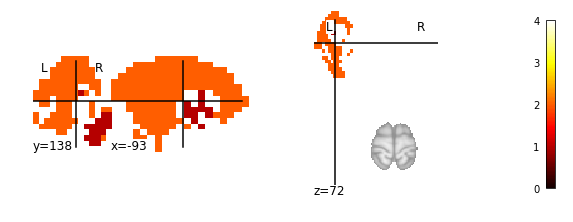

In [56]:
## Prediction visualisation
import nibabel
from matplotlib import pyplot as plt 
import numpy as np
from nilearn import plotting
import plotly.plotly as py
import plotly.graph_objs as go

# Before 
#org = nibabel.load('/data/home/vjain/notebooks/3DUnetCNN/brats/prediction/validation_case_18/truth.nii.gz')
org = nibabel.load(os.path.abspath('prediction/validation_case_14/truth.nii.gz'))


plotting.plot_stat_map(org,threshold='auto')


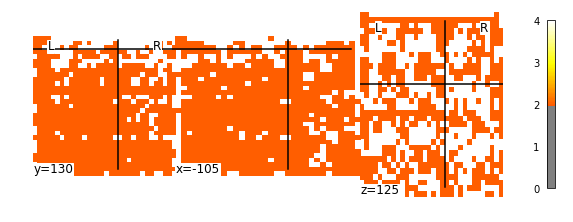

In [57]:
import nibabel
from matplotlib import pyplot as plt 
import numpy as np
from nilearn import plotting
import plotly.plotly as py
import plotly.graph_objs as go

# Before 
#org = nibabel.load('/data/home/vjain/notebooks/3DUnetCNN/brats/prediction/validation_case_18/prediction.nii.gz')
org = nibabel.load(os.path.abspath('prediction/validation_case_14/prediction.nii.gz'))
plotting.plot_stat_map(org,threshold='auto')


import nibabel
from matplotlib import pyplot as plt 
import numpy as np
from nilearn import plotting
import plotly.plotly as py
import plotly.graph_objs as go

# Before 
org = nibabel.load('/data/home/vjain/notebooks/3DUnetCNN/brats/prediction/validation_case_11/prediction.nii.gz')

plotting.plot_stat_map(org,threshold='auto')


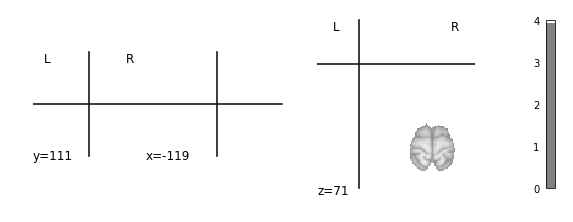

In [58]:
import nibabel
from matplotlib import pyplot as plt 
import numpy as np
from nilearn import plotting
import plotly.plotly as py
import plotly.graph_objs as go

# Before 
org = nibabel.load('/data/home/vjain/notebooks/3DUnetCNN/brats/v_1_50/prediction/validation_case_11/prediction.nii.gz')

plotting.plot_stat_map(org,threshold='auto')
